In [20]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence, to_categorical

In [21]:
data_path = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
num_samples = 290
target_shape = (128, 128, 128)
num_classes = 4
batch_size = 1
epochs = 15

In [22]:
def normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)
    return (img - min_val) / (max_val - min_val) if max_val > min_val else np.zeros_like(img)

def resize_volume(img, target_shape=(128, 128, 128)):
    zoom_factors = [t / s for t, s in zip(target_shape, img.shape)]
    return zoom(img, zoom_factors, order=1)

def load_and_preprocess(data_dir):
    basename = os.path.basename(data_dir)
    flair = nib.load(os.path.join(data_dir, f'{basename}_flair.nii')).get_fdata()
    t1 = nib.load(os.path.join(data_dir, f'{basename}_t1.nii')).get_fdata()
    t1ce = nib.load(os.path.join(data_dir, f'{basename}_t1ce.nii')).get_fdata()
    t2 = nib.load(os.path.join(data_dir, f'{basename}_t2.nii')).get_fdata()
    seg = nib.load(os.path.join(data_dir, f'{basename}_seg.nii')).get_fdata()

    # Normalize and resize
    flair = resize_volume(normalize(flair))
    t1 = resize_volume(normalize(t1))
    t1ce = resize_volume(normalize(t1ce))
    t2 = resize_volume(normalize(t2))
    image = np.stack([flair, t1, t1ce, t2], axis=-1).astype(np.float32)

    # Remap labels: 0, 1, 2, 4 → 0, 1, 2, 3
    remapped_seg = np.zeros_like(seg, dtype=np.uint8)
    remapped_seg[seg == 1] = 1
    remapped_seg[seg == 2] = 2
    remapped_seg[seg == 4] = 3
    remapped_seg = resize_volume(remapped_seg, target_shape=target_shape).astype(np.uint8)

    return image, remapped_seg


In [23]:
class BraTSDatasetGenerator(Sequence):
    def __init__(self, data_dirs, batch_size=1, target_shape=(128, 128, 128), num_classes=4, shuffle=True):
        self.data_dirs = data_dirs
        self.batch_size = batch_size
        self.target_shape = target_shape
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data_dirs) / self.batch_size))

    def __getitem__(self, index):
        batch_dirs = self.data_dirs[index * self.batch_size : (index + 1) * self.batch_size]
        images, segmentations = zip(*[load_and_preprocess(d) for d in batch_dirs])

        images = np.array(images, dtype=np.float32)
        segmentations = np.array(segmentations, dtype=np.uint8)
        segmentations = np.expand_dims(segmentations, axis=-1)
        segmentations = to_categorical(segmentations, num_classes=self.num_classes).astype(np.float32)

        return images, segmentations

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.data_dirs)


In [24]:
def mtc_net_3d(input_shape=(128, 128, 128, 4), num_classes=4):
    inputs = Input(input_shape)

    conv1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)

    conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)

    conv3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool2)

    up4 = UpSampling3D((2, 2, 2))(conv3)
    merge4 = concatenate([conv2, up4], axis=-1)
    conv4 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(merge4)

    up5 = UpSampling3D((2, 2, 2))(conv4)
    merge5 = concatenate([conv1, up5], axis=-1)
    conv5 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(merge5)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [25]:
training_dirs = [os.path.join(data_path, d) for d in os.listdir(data_path)
                 if os.path.isdir(os.path.join(data_path, d)) and 'BraTS20_Training' in d]
training_dirs.sort()
training_dirs = training_dirs[:num_samples]

# Split into train and validation sets
train_dirs, val_dirs = train_test_split(training_dirs, test_size=0.2, random_state=42)

train_gen = BraTSDatasetGenerator(train_dirs, batch_size=batch_size, target_shape=target_shape, num_classes=num_classes)
val_gen = BraTSDatasetGenerator(val_dirs, batch_size=batch_size, target_shape=target_shape, num_classes=num_classes)


In [ ]:
# ---------------------- Train ----------------------
input_shape = (128, 128, 128, 4)
model = mtc_net_3d(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=1)

# ---------------------- Save ----------------------
model.save("brats_mtc_net_model.h5")
print("✅ Model saved to brats_mtc_net_model.h5")


C:\Users\amara\Downloads\DIP PROJECT\my_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 1791s 8s/step - accuracy: 0.9356 - loss: 0.7024 - val_accuracy: 0.9886 - val_loss: 0.0532
Epoch 2/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 1770s 8s/step - accuracy: 0.9892 - loss: 0.0477 - val_accuracy: 0.9886 - val_loss: 0.0457
Epoch 3/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 1773s 8s/step - accuracy: 0.9893 - loss: 0.0423 - val_accuracy: 0.9886 - val_loss: 0.0440
Epoch 4/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 1822s 8s/step - accuracy: 0.9893 - loss: 0.0404 - val_accuracy: 0.9891 - val_loss: 0.0423
Epoch 5/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 1773s 8s/step - accuracy: 0.9895 - loss: 0.0398 - val_accuracy: 0.9897 - val_loss: 0.0415
Epoch 6/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 1774s 8s/step - accuracy: 0.9900 - loss: 0.0384 - val_accuracy: 0.9891 - val_loss: 0.0435
Epoch 7/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 1771s 8s/step - accuracy: 0.9894 - loss: 0.0403 - val_accuracy: 0.9900 - val_loss: 0.0376
Epoch 8/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 1776s 8s/step - accuracy: 0.9898 - loss: 0.0382 - 

✅ Model saved to brats3d_unet_model.h5


In [25]:
model.save("brats_mtcnet_model.h5")
print("✅ Model saved to brats_mtcnet_model.h5")


✅ Model saved to brats_mtcnet_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


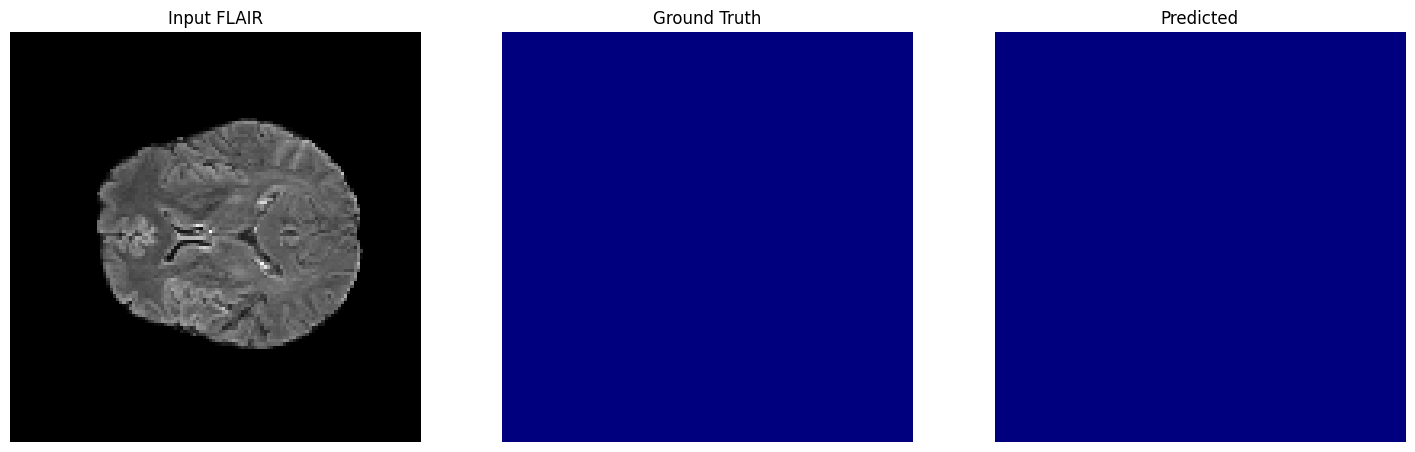

In [25]:
import matplotlib.pyplot as plt

def visualize_prediction(model, generator, sample_index=2):
    image_batch, mask_batch = generator[sample_index]  # Get a batch
    image = image_batch[0]
    mask = np.argmax(mask_batch[0], axis=-1)

    # Predict
    pred = model.predict(np.expand_dims(image, axis=0))[0]
    pred_mask = np.argmax(pred, axis=-1)

    # Choose a middle slice (Axial view)
    slice_index = image.shape[2] // 2

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    axs[0].imshow(image[:, :, slice_index, 0], cmap='gray')  # Flair modality
    axs[0].set_title("Input FLAIR")
    axs[0].axis('off')

    axs[1].imshow(mask[:, :, slice_index], cmap='jet', interpolation='none', vmin=0, vmax=num_classes-1)
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred_mask[:, :, slice_index], cmap='jet', interpolation='none', vmin=0, vmax=num_classes-1)
    axs[2].set_title("Predicted")
    axs[2].axis('off')

    plt.show()

# Example usage
visualize_prediction(model, train_gen, sample_index=2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


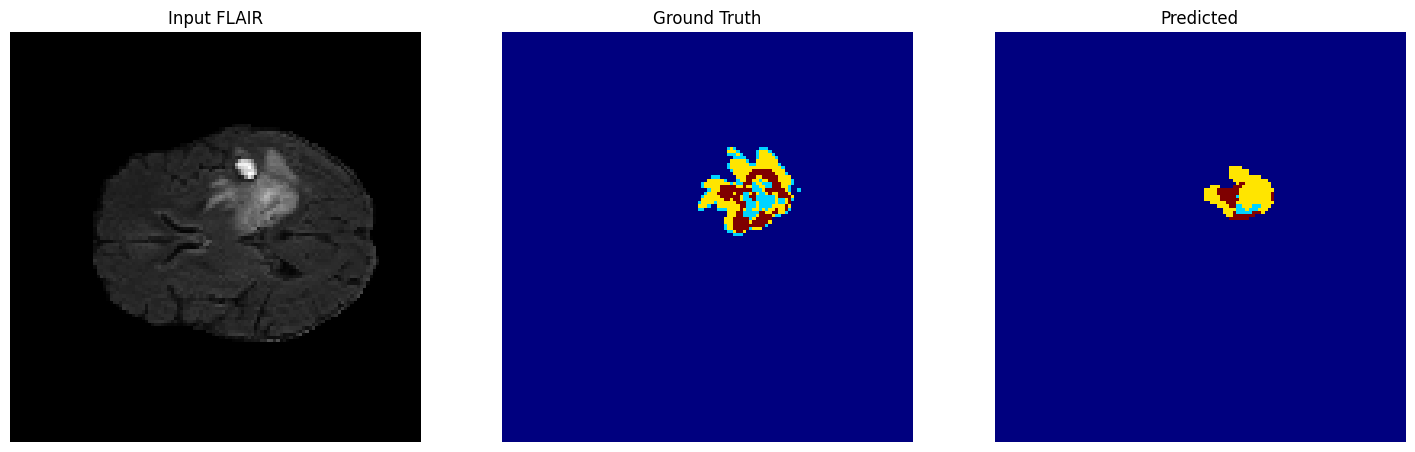

In [27]:
import matplotlib.pyplot as plt

def visualize_prediction(model, generator, sample_index=21):
    image_batch, mask_batch = generator[sample_index]  # Get a batch
    image = image_batch[0]
    mask = np.argmax(mask_batch[0], axis=-1)

    # Predict
    pred = model.predict(np.expand_dims(image, axis=0))[0]
    pred_mask = np.argmax(pred, axis=-1)

    # Choose a middle slice (Axial view)
    slice_index = image.shape[2] // 2

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    axs[0].imshow(image[:, :, slice_index, 0], cmap='gray')  # Flair modality
    axs[0].set_title("Input FLAIR")
    axs[0].axis('off')

    axs[1].imshow(mask[:, :, slice_index], cmap='jet', interpolation='none', vmin=0, vmax=num_classes-1)
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred_mask[:, :, slice_index], cmap='jet', interpolation='none', vmin=0, vmax=num_classes-1)
    axs[2].set_title("Predicted")
    axs[2].axis('off')

    plt.show()

# Example usage
visualize_prediction(model, train_gen, sample_index=21)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


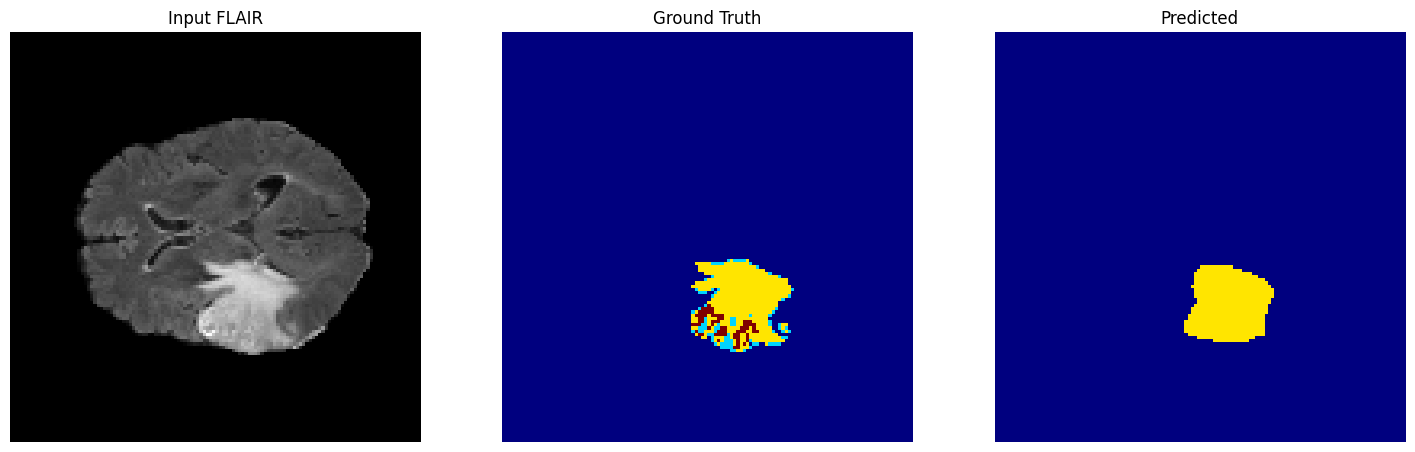

In [29]:
import matplotlib.pyplot as plt

def visualize_prediction(model, generator, sample_index=120):
    image_batch, mask_batch = generator[sample_index]  # Get a batch
    image = image_batch[0]
    mask = np.argmax(mask_batch[0], axis=-1)

    # Predict
    pred = model.predict(np.expand_dims(image, axis=0))[0]
    pred_mask = np.argmax(pred, axis=-1)

    # Choose a middle slice (Axial view)
    slice_index = image.shape[2] // 2

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    axs[0].imshow(image[:, :, slice_index, 0], cmap='gray')  # Flair modality
    axs[0].set_title("Input FLAIR")
    axs[0].axis('off')

    axs[1].imshow(mask[:, :, slice_index], cmap='jet', interpolation='none', vmin=0, vmax=num_classes-1)
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred_mask[:, :, slice_index], cmap='jet', interpolation='none', vmin=0, vmax=num_classes-1)
    axs[2].set_title("Predicted")
    axs[2].axis('off')

    plt.show()

# Example usage
visualize_prediction(model, train_gen, sample_index=120)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


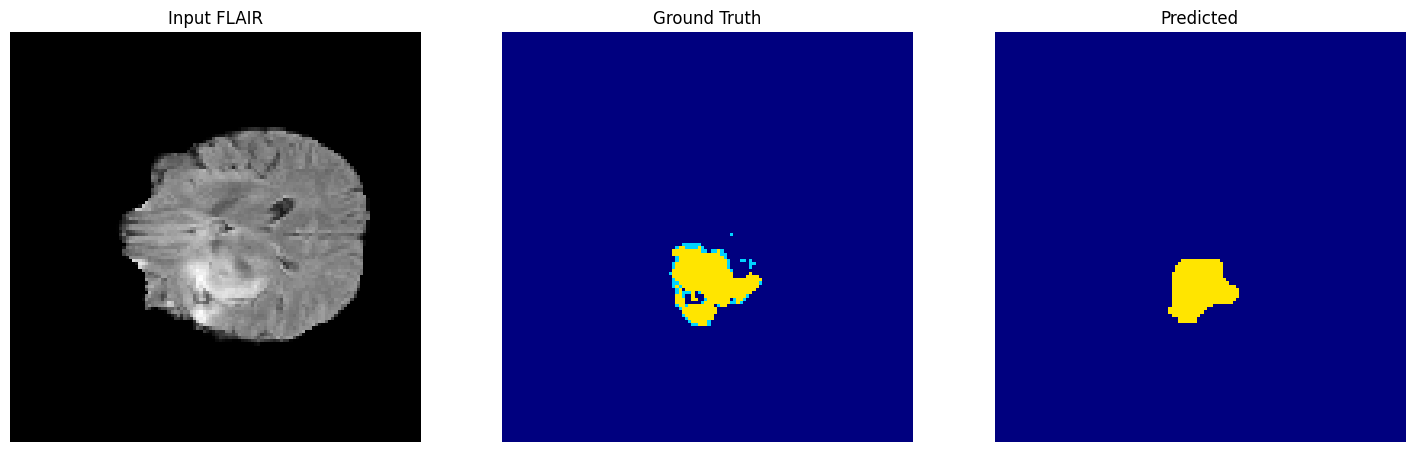

In [26]:
import matplotlib.pyplot as plt

def visualize_prediction(model, generator, sample_index=4):
    image_batch, mask_batch = generator[sample_index]  # Get a batch
    image = image_batch[0]
    mask = np.argmax(mask_batch[0], axis=-1)

    # Predict
    pred = model.predict(np.expand_dims(image, axis=0))[0]
    pred_mask = np.argmax(pred, axis=-1)

    # Choose a middle slice (Axial view)
    slice_index = image.shape[2] // 2

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    axs[0].imshow(image[:, :, slice_index, 0], cmap='gray')  # Flair modality
    axs[0].set_title("Input FLAIR")
    axs[0].axis('off')

    axs[1].imshow(mask[:, :, slice_index], cmap='jet', interpolation='none', vmin=0, vmax=num_classes-1)
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred_mask[:, :, slice_index], cmap='jet', interpolation='none', vmin=0, vmax=num_classes-1)
    axs[2].set_title("Predicted")
    axs[2].axis('off')

    plt.show()

# Example usage
visualize_prediction(model, train_gen, sample_index=4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


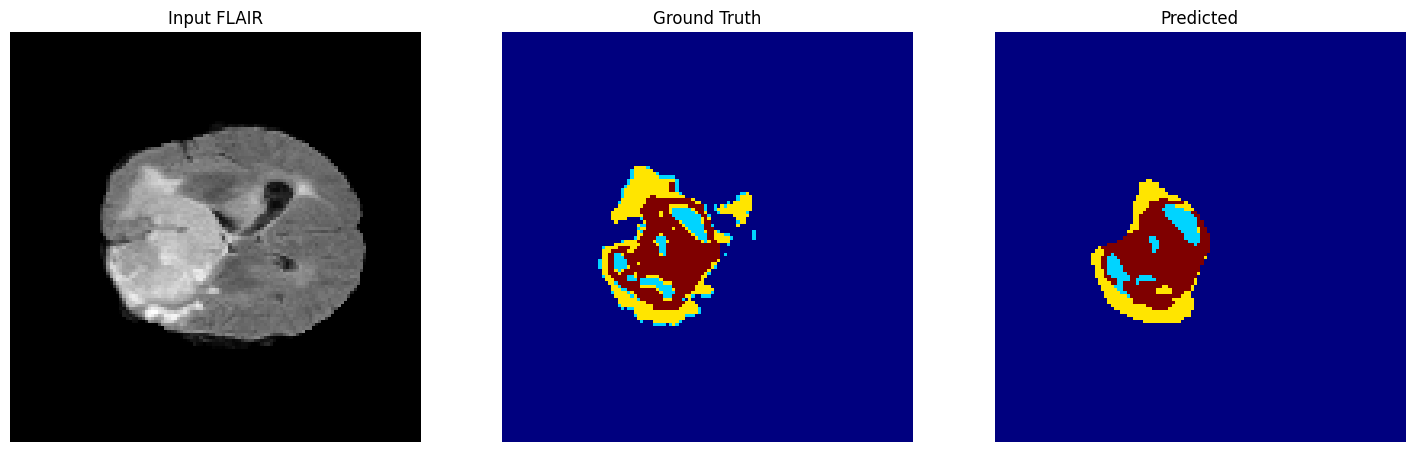

In [31]:
import matplotlib.pyplot as plt

def visualize_prediction(model, generator, sample_index=45):
    image_batch, mask_batch = generator[sample_index]  # Get a batch
    image = image_batch[0]
    mask = np.argmax(mask_batch[0], axis=-1)

    # Predict
    pred = model.predict(np.expand_dims(image, axis=0))[0]
    pred_mask = np.argmax(pred, axis=-1)

    # Choose a middle slice (Axial view)
    slice_index = image.shape[2] // 2

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    axs[0].imshow(image[:, :, slice_index, 0], cmap='gray')  # Flair modality
    axs[0].set_title("Input FLAIR")
    axs[0].axis('off')

    axs[1].imshow(mask[:, :, slice_index], cmap='jet', interpolation='none', vmin=0, vmax=num_classes-1)
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred_mask[:, :, slice_index], cmap='jet', interpolation='none', vmin=0, vmax=num_classes-1)
    axs[2].set_title("Predicted")
    axs[2].axis('off')

    plt.show()

# Example usage
visualize_prediction(model, train_gen, sample_index=45)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


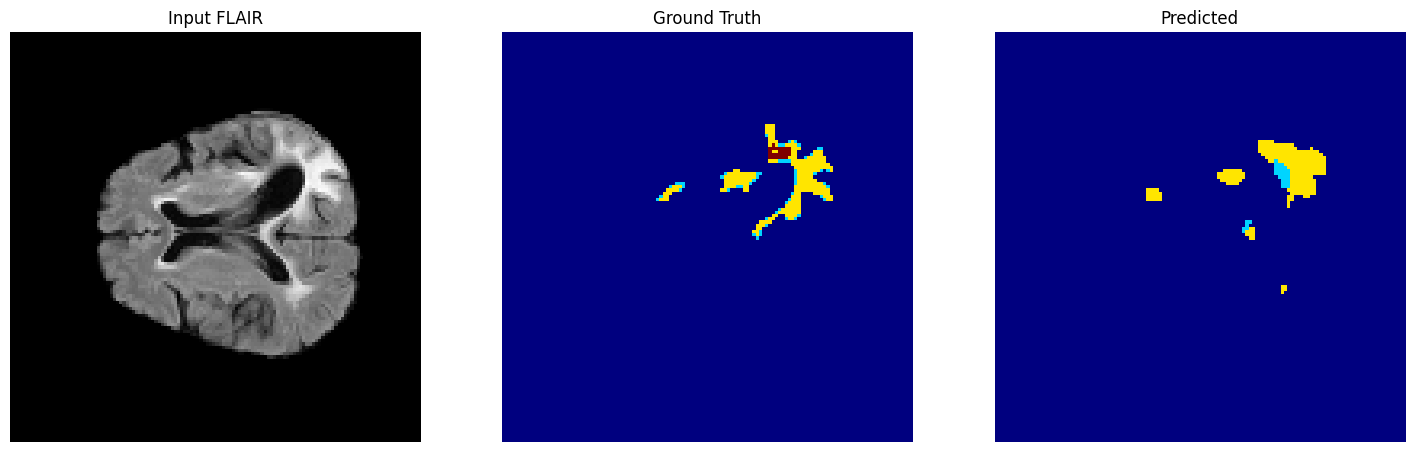

In [43]:
def visualize_prediction_by_patient(model, data_dirs, patient_id, target_shape, num_classes):
    import matplotlib.pyplot as plt

    # Locate the correct patient directory
    patient_dir = next((d for d in data_dirs if d.endswith(str(patient_id))), None)
    
    if patient_dir is None:
        print(f"Patient ID {patient_id} not found in provided dirs.")
        return

    # Use a single-patient generator
    gen = BraTSDatasetGenerator([patient_dir], batch_size=1, target_shape=target_shape, num_classes=num_classes)
    image_batch, mask_batch = gen[0]
    
    image = image_batch[0]
    mask = np.argmax(mask_batch[0], axis=-1)

    # Predict the segmentation mask
    pred = model.predict(np.expand_dims(image, axis=0))[0]
    pred_mask = np.argmax(pred, axis=-1)

    # Middle axial slice
    slice_index = image.shape[2] // 2

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(image[:, :, slice_index, 0], cmap='gray')
    axs[0].set_title("Input FLAIR")
    axs[0].axis('off')

    axs[1].imshow(mask[:, :, slice_index], cmap='jet', vmin=0, vmax=num_classes-1)
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred_mask[:, :, slice_index], cmap='jet', vmin=0, vmax=num_classes-1)
    axs[2].set_title("Predicted")
    axs[2].axis('off')

    plt.show()
visualize_prediction_by_patient(model, extra_val_dirs, patient_id=345, target_shape=target_shape, num_classes=num_classes)


In [32]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [33]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', dice_coefficient])


In [34]:
val_metrics = model.evaluate(val_gen, verbose=1)
print(f"📊 Validation Loss: {val_metrics[0]:.4f}")
print(f"📈 Validation Accuracy: {val_metrics[1]:.4f}")
print(f"🎯 Validation Dice Coefficient: {val_metrics[2]:.4f}")


C:\Users\amara\Downloads\DIP PROJECT\my_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.9912 - dice_coefficient: 0.9840 - loss: 0.0297
📊 Validation Loss: 0.0304
📈 Validation Accuracy: 0.9913
🎯 Validation Dice Coefficient: 0.9833


In [35]:

extra_val_dirs = [os.path.join(data_path, d) for d in os.listdir(data_path)
                  if os.path.isdir(os.path.join(data_path, d)) and 'BraTS20_Training' in d]
extra_val_dirs.sort()
extra_val_dirs = extra_val_dirs[num_samples:369] 

# Create generator
extra_val_gen = BraTSDatasetGenerator(extra_val_dirs, batch_size=batch_size, target_shape=target_shape, num_classes=num_classes)


In [36]:
val_metrics = model.evaluate(extra_val_gen, verbose=1)
print(f"📊 Validation Loss: {val_metrics[0]:.4f}")
print(f"📈 Validation Accuracy: {val_metrics[1]:.4f}")
print(f"🎯 Validation Dice Coefficient: {val_metrics[2]:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.9880 - dice_coefficient: 0.9743 - loss: 0.0416
📊 Validation Loss: 0.0392
📈 Validation Accuracy: 0.9886
🎯 Validation Dice Coefficient: 0.9764


In [49]:
def evaluate_per_class_dice(model, generator, num_classes):
    dice_scores = np.zeros(num_classes)
    counts = np.zeros(num_classes)

    for i in range(len(generator)):
        x, y_true = generator[i]
        y_pred = model.predict(x)

        y_true = np.argmax(y_true, axis=-1)
        y_pred = np.argmax(y_pred, axis=-1)

        for cls in range(num_classes):
            if cls == 1:
                continue  
            intersection = np.sum((y_pred == cls) & (y_true == cls))
            union = np.sum((y_pred == cls) + (y_true == cls))
            if union != 0:
                dice_scores[cls] += 2. * intersection / union
                counts[cls] += 1

    avg_dice = np.divide(dice_scores, counts, out=np.zeros_like(dice_scores), where=counts != 0)

   
    valid_scores = [avg_dice[cls] for cls in range(num_classes) if cls != 1]
    mean_dice = np.mean(valid_scores)

    mean_dice_score = float(mean_dice)  
    print(f"{mean_dice_score:.4f}")
    
    return mean_dice_score


In [50]:
mean_dice_score=evaluate_per_class_dice(model, extra_val_gen, num_classes=num_classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [52]:
print(f"Dice_coeffient for validation dataset: {mean_dice_score:.4f}")

Dice_coeffient for validation dataset: 0.8631


In [9]:


# 📦 Imports
import os
import pandas as pd
import numpy as np
import nibabel as nib
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# 📁 Paths
csv_path = 'survival.csv'
nii_base_path = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

# 📄 Load CSV
survival_df = pd.read_csv(csv_path)

print(f"CSV Loaded: {survival_df.shape[0]} rows")

# 🧠 Feature Extraction from segmentation (seg.nii)
def extract_volume_features(patient_id, base_path):
    try:
        seg_path = os.path.join(base_path, patient_id, f"{patient_id}_seg.nii")
        seg_img = nib.load(seg_path)
        seg_data = seg_img.get_fdata()

        wt_volume = np.sum(seg_data > 0)  # Whole tumor
        tc_volume = np.sum(np.isin(seg_data, [1, 4]))  # Tumor core (NET/NCR + ET)
        et_volume = np.sum(seg_data == 4)  # Enhancing tumor

        return {
            "Brats20ID": patient_id,
            "WT_Volume": wt_volume,
            "TC_Volume": tc_volume,
            "ET_Volume": et_volume
        }
    except FileNotFoundError:
        return None

# 🧾 Extract features for patients available in CSV
volume_features = []
for pid in tqdm(survival_df["Brats20ID"], desc="Extracting features"):
    features = extract_volume_features(pid, nii_base_path)
    if features:
        volume_features.append(features)

features_df = pd.DataFrame(volume_features)
print(f"Features extracted: {features_df.shape[0]} patients")

# 🔗 Merge CSV and volume features
df = pd.merge(survival_df, features_df, on="Brats20ID")
print(f"Merged shape: {df.shape}")

# 🔢 Encode categorical feature
le = LabelEncoder()
df['ResectionEncoded'] = le.fit_transform(df['Extent_of_Resection'])

# 🎯 Prepare X and y
X = df[['Age', 'ResectionEncoded', 'WT_Volume', 'TC_Volume', 'ET_Volume']]
y = df['Survival_days']

# 📊 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ⚙️ Train Model
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
model.fit(X_train, y_train)

# 📈 Predict and Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n✅ Mean Absolute Error on test set: {mae:.2f} days")



CSV Loaded: 236 rows


Extracting features: 100%|███████████████████████████████████████████████████████████| 236/236 [01:03<00:00,  3.71it/s]


Features extracted: 236 patients
Merged shape: (236, 7)

✅ Mean Absolute Error on test set: 329.43 days


In [10]:
def extract_modality_features(patient_id, base_path):
    modalities = ['t1', 't1ce', 't2', 'flair']
    features = {"Brats20ID": patient_id}

    try:
        for modality in modalities:
            path = os.path.join(base_path, patient_id, f"{patient_id}_{modality}.nii")
            img = nib.load(path)
            data = img.get_fdata()
            masked_data = data[data > 0]  # ignore background

            if masked_data.size > 0:
                features[f'{modality}_mean'] = np.mean(masked_data)
                features[f'{modality}_std'] = np.std(masked_data)
                features[f'{modality}_p95'] = np.percentile(masked_data, 95)
            else:
                features[f'{modality}_mean'] = 0
                features[f'{modality}_std'] = 0
                features[f'{modality}_p95'] = 0
        return features
    except FileNotFoundError:
        return None


In [11]:
# Extract features for all patients
from tqdm import tqdm

all_features = []
for pid in tqdm(survival_df["Brats20ID"], desc="Extracting full features"):
    vol_feats = extract_volume_features(pid, nii_base_path)
    mod_feats = extract_modality_features(pid, nii_base_path)

    if vol_feats and mod_feats:
        combined = {**vol_feats, **mod_feats}
        all_features.append(combined)

features_df = pd.DataFrame(all_features)
df = pd.merge(survival_df, features_df, on='Brats20ID')

# Encode Resection Type
df['ResectionEncoded'] = le.fit_transform(df['Extent_of_Resection'])

# Define X and y
modality_features = [col for col in df.columns if any(m in col for m in ['t1', 't1ce', 't2', 'flair'])]
X = df[['Age', 'ResectionEncoded', 'WT_Volume', 'TC_Volume', 'ET_Volume'] + modality_features]
y = df['Survival_days']


Extracting full features: 100%|██████████████████████████████████████████████████████| 236/236 [04:31<00:00,  1.15s/it]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.05)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [13]:
model = XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.05)
model.fit(X, y)  # Train on ALL data


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=150,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
import joblib

# Save the model to a file
joblib.dump(model, 'xgb_survival_model.pkl')
print("Model saved to xgb_survival_model.pkl")
model = joblib.load('xgb_survival_model.pkl')

Model saved to xgb_survival_model.pkl


In [15]:
y_pred_all = model.predict(X)


In [16]:
comparison_all_df = pd.DataFrame({
    'Brats20ID': df['Brats20ID'],
    'Actual_Survival_days': y,
    'Predicted_Survival_days': y_pred_all.astype(int)
})


In [17]:
print("\n📋 Full Actual vs Predicted (first 10 samples):")
print(comparison_all_df)



📋 Full Actual vs Predicted (first 10 samples):
                Brats20ID  Actual_Survival_days  Predicted_Survival_days
0    BraTS20_Training_001                   289                      299
1    BraTS20_Training_002                   616                      547
2    BraTS20_Training_003                   464                      472
3    BraTS20_Training_004                   788                      801
4    BraTS20_Training_005                   465                      499
..                    ...                   ...                      ...
231  BraTS20_Training_363                    62                      208
232  BraTS20_Training_366                   633                      547
233  BraTS20_Training_367                   437                      410
234  BraTS20_Training_368                   442                      427
235  BraTS20_Training_369                   145                      186

[236 rows x 3 columns]


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import pearsonr

# Ground truth and predictions
y_true = comparison_all_df['Actual_Survival_days'].values
y_pred = comparison_all_df['Predicted_Survival_days'].values

# 1. Mean Absolute Error
mae = mean_absolute_error(y_true, y_pred)

# 2. Mean Squared Error
mse = mean_squared_error(y_true, y_pred)

# 3. Root Mean Squared Error
rmse = np.sqrt(mse)

# 4. R² Score
r2 = r2_score(y_true, y_pred)

# 5. Mean Absolute Percentage Error
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 6. Pearson Correlation Coefficient
corr, _ = pearsonr(y_true, y_pred)

# 📋 Print All
print("📊 Evaluation Metrics:")
print(f"✅ Mean Absolute Error (MAE): {mae:.2f}")
print(f"✅ Mean Squared Error (MSE): {mse:.2f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"✅ R² Score: {r2:.4f}")
print(f"✅ Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"✅ Pearson Correlation (r): {corr:.4f}")


📊 Evaluation Metrics:
✅ Mean Absolute Error (MAE): 42.42
✅ Mean Squared Error (MSE): 3558.98
✅ Root Mean Squared Error (RMSE): 59.66
✅ R² Score: 0.9717
✅ Mean Absolute Percentage Error (MAPE): 37.65%
✅ Pearson Correlation (r): 0.9916


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

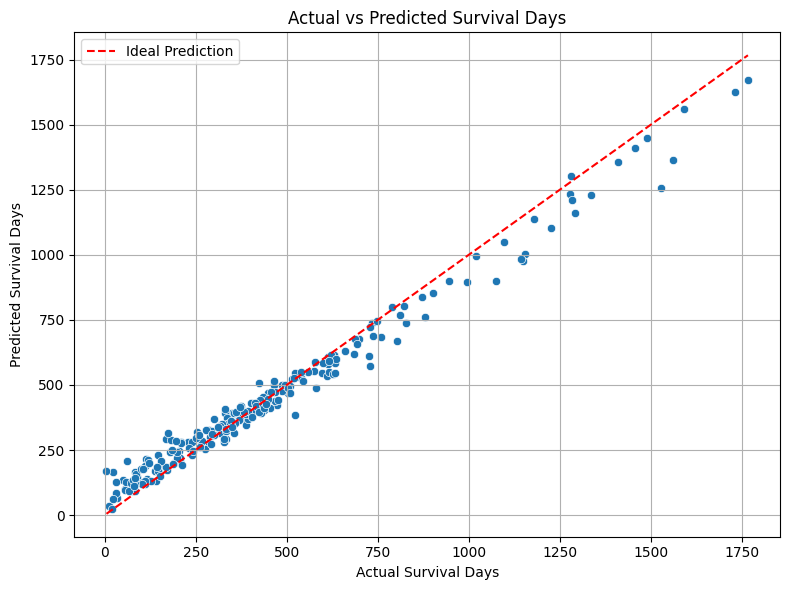

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('Actual Survival Days')
plt.ylabel('Predicted Survival Days')
plt.title('Actual vs Predicted Survival Days')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

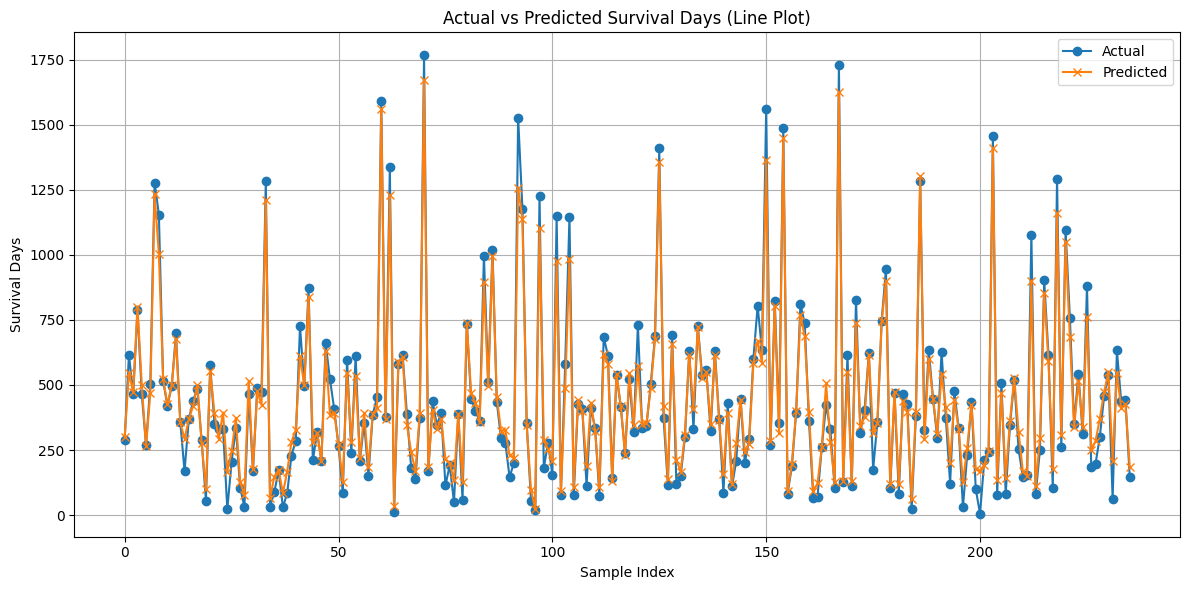

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Survival Days')
plt.title('Actual vs Predicted Survival Days (Line Plot)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
import numpy as np

tolerance =90
accurate_preds = np.abs(y_true - y_pred) <= tolerance
accuracy = np.mean(accurate_preds) * 100

print(f"Custom Accuracy within ±{tolerance} days: {accuracy:.2f}%")


Custom Accuracy within ±90 days: 88.98%


In [42]:
import numpy as np

tolerance =100
accurate_preds = np.abs(y_true - y_pred) <= tolerance
accuracy = np.mean(accurate_preds) * 100

print(f"Custom Accuracy within ±{tolerance} days: {accuracy:.2f}%")


Custom Accuracy within ±100 days: 90.68%
